# Configuring to download the kaggle dataset

In [10]:
# Configuring the path for kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
# Downloading the data

!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:06<00:00, 173MB/s]
100% 812M/812M [00:06<00:00, 123MB/s]


# Importing useful libraries

In [89]:
from zipfile import ZipFile # For unzipping the downloaded data
import os # For doing directory related tasks

import numpy as np # For numerical related tasks
import matplotlib.pyplot as plt # For visualizations
import cv2 # For image related tasks
from PIL import Image # For image related tasks

# For model training
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

import pickle # For model saving

In [13]:
# Let us unzip the data

dataset_path = '/content/dogs-vs-cats.zip'

with ZipFile(dataset_path,'r') as zip:
  zip.extractall()

In [14]:
# Now let us unzip the train file

train_data_path = '/content/train.zip'

with ZipFile(train_data_path,'r') as zip:
  zip.extractall()

In [15]:
# Let us see how many images are in the training set

num_images = len(os.listdir('/content/train'))
print(f'We have {num_images} number of images in the training set')

We have 25000 number of images in the training set


# EDA

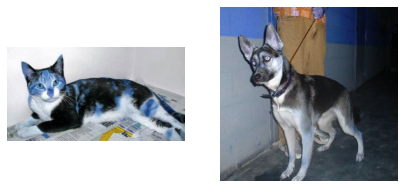

In [16]:
# Let us see some images in the train folder

fig = plt.figure(figsize=(7,7))

file_names = os.listdir('/content/train')
cat_image = cv2.imread('/content/train/cat.10434.jpg')
dog_image = cv2.imread('/content/train/dog.2810.jpg')

fig.add_subplot(1,2,1)
plt.imshow(cat_image)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(dog_image)
plt.axis('off')

plt.show()

In [17]:
# Let us see how many dogs and cats are in our dataset

dog_counts = 0
cat_counts = 0

for file in file_names:

  if file[:3] == 'cat':
    cat_counts += 1
  
  if file[:3] == 'dog':
    dog_counts += 1

print(f'We have {dog_counts} dogs and {cat_counts} cats in the dataset')

We have 12500 dogs and 12500 cats in the dataset


In [18]:
# Let us create a new directory for which we will take some images and resize them

!mkdir resized_images

In [25]:
# Now let us resize 2000 images and perform the image reshaping

original_folder = '/content/train/'
resized_folder = '/content/resized_images/'

for i in range(2000):

  file_name = os.listdir(original_folder)[i]
  img_path = original_folder + file_name

  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert('RGB')

  new_img_path = resized_folder + file_name
  img.save(new_img_path)

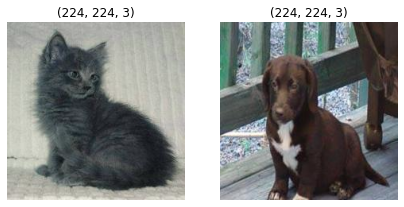

In [30]:
# Let us see some images in the resized folder

fig = plt.figure(figsize=(7,7))

resized_folder = '/content/resized_images'
cat_image = cv2.imread(resized_folder + '/cat.9532.jpg')
dog_image = cv2.imread(resized_folder + '/dog.10847.jpg')

fig.add_subplot(1,2,1)
plt.imshow(cat_image)
plt.title(cat_image.shape)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(dog_image)
plt.title(dog_image.shape)
plt.axis('off')

plt.show()

In [52]:
# Let us create a label for the resized images

file_names = os.listdir('/content/resized_images')
labels = []
for i in range(len(file_names)):
  image = file_names[i]
  label = image[:3]

  if label == 'cat':
    labels.append(0)
  else:
    labels.append(1)

In [53]:
# Let us see if we succesfuly labeled our data

print(file_names[:10])
print(labels[:10])

['dog.7170.jpg', 'dog.238.jpg', 'dog.2314.jpg', 'cat.1745.jpg', 'cat.11324.jpg', 'cat.5973.jpg', 'cat.1545.jpg', 'cat.6826.jpg', 'cat.2232.jpg', 'cat.12002.jpg']
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [54]:
# Let us see how many dogs and cats are in our data

values,counts = np.unique(labels,return_counts=True)
print(values)
print(counts)

[0 1]
[ 999 1001]


In [39]:
# Let us change all the images into numpy array

resized_image_folder = '/content/resized_images/'
dog_cat_images = []
for i in range(2000):
  img_path = resized_image_folder + os.listdir(resized_image_folder)[i]
  img = cv2.imread(img_path)
  dog_cat_images.append(img)
dog_cat_images = np.array(dog_cat_images)
dog_cat_images.shape

(2000, 224, 224, 3)

In [55]:
# Now let us get our features and labels

X = dog_cat_images
y = np.array(labels)

In [56]:
# Let us do the train test split

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 stratify = y,
                                                 test_size = 0.2,
                                                 random_state = 1
                                                 )

In [57]:
# Lets see the shape of each split

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(1600, 224, 224, 3)
(400, 224, 224, 3)
(400,)
(1600,)


In [58]:
# For better accuracy let us scale the data

X_train = X_train / 255
X_test = X_test / 255

# Model training

In [59]:
# Since we are trying to do transfer learning let us call the mobile net model

mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pre_trained_model = hub.KerasLayer(
    mobilenet_model,
    input_shape = (224,224,3),
    trainable = False
)

In [60]:
# Now let us add the last layer in the neural network

num_class = 2

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Dense(num_class)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [63]:
# Let us compile our model

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [64]:
# Let us train the model 

model.fit(X_train,y_train,
          validation_split = 0.1,
          epochs = 5
          )

Epoch 1/5
45/45 [==============================] - 53s 1s/step - loss: 0.1764 - accuracy: 0.9299 - val_loss: 0.0813 - val_accuracy: 0.9688
Epoch 2/5
45/45 [==============================] - 50s 1s/step - loss: 0.0650 - accuracy: 0.9771 - val_loss: 0.0778 - val_accuracy: 0.9688
Epoch 3/5
45/45 [==============================] - 50s 1s/step - loss: 0.0448 - accuracy: 0.9882 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 4/5
45/45 [==============================] - 48s 1s/step - loss: 0.0368 - accuracy: 0.9861 - val_loss: 0.0501 - val_accuracy: 0.9875
Epoch 5/5
45/45 [==============================] - 48s 1s/step - loss: 0.0286 - accuracy: 0.9917 - val_loss: 0.0467 - val_accuracy: 0.9812


# Model evaluation

In [67]:
# Let us see the test set accuracy

_ , accuracy = model.evaluate(X_test,y_test)
print(f'The test set accuracy is {np.round(accuracy*100,2)}%')

13/13 [==============================] - 15s 1s/step - loss: 0.0670 - accuracy: 0.9800
The test set accuracy is 98.0%


In [81]:
# Let us create a predictive system

def predicting_function():

  img_path = input("Please enter the image path: ")

  try:
    image = cv2.imread(img_path)
    resized_image = cv2.resize(image,(224,224))
    scaled_image = resized_image / 255
    reshaped_input = np.expand_dims(scaled_image,0)
    pred = model.predict(reshaped_input)
    if np.argmax(pred) == 0:
      plt.title('The predicted class is cat')
    else:
      plt.title('The predicted class is dog')

    plt.imshow(scaled_image)
    plt.axis('off')
    plt.show()
    
  except:
    print("You passed a path that is not correct!!!")

Please enter the image path: /content/cat_image.jpg
1/1 [==============================] - 0s 103ms/step


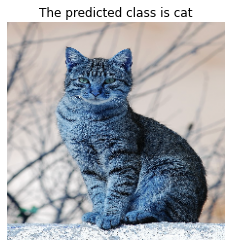

In [82]:
# First cat image test

predicting_function()

Please enter the image path: /content/cat_image_2.jpg
1/1 [==============================] - 0s 67ms/step


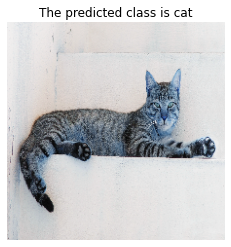

In [83]:
# Second cat image test

predicting_function()

Please enter the image path: /content/cat_image_3.jpg
1/1 [==============================] - 0s 63ms/step


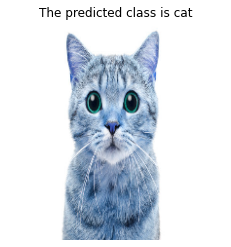

In [84]:
# Third cat image test

predicting_function()

Please enter the image path: /content/dog_image.jpeg
1/1 [==============================] - 0s 68ms/step


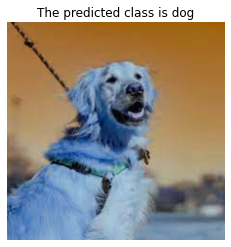

In [85]:
# First dog image test

predicting_function()

Please enter the image path: /content/dog_image_2.webp
1/1 [==============================] - 0s 65ms/step


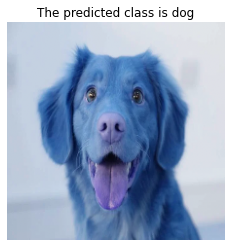

In [86]:
# Second dog image test

predicting_function()

Please enter the image path: /content/dog_image_3.jpeg
1/1 [==============================] - 0s 64ms/step


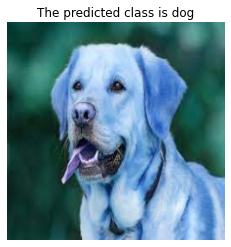

In [87]:
# Third dog image test

predicting_function()

# Saving the model

In [90]:
# Saving the model as h5 file

model_path = '/content/models/cat_dog_classification.h5'
with open(model_path,'wb') as f:
  pickle.dump(model,f)